# Методы ценообразования опционов.Часть 2

* <font size='5'>Black-Scholes</font>
* <font size='5'>Monte-Carlo simulation</font>

## Цели и  задачи:
### 1. Изучить подходы к моделированию опционов методом Monte Carlo
### 2. Получить навык работы с классами  Python
### 3. Получить дополнительные навыки работы с библиотеками NumPy и Pandas

### Рекомендуемая литература:
### 1.Levy G. Computational Finance. Numerical Methods for Pricing Financial Instruments
### 2.Neftci N.S. An Introduction to the Mathematics of Financial Derivatives
### 3.Hilpisch Y. Derivatives Analytics with Python: Data Analysis, Models, Simulation, Calibration and Hedging
### 4.London J. Modelling Derivatives with C++
### 5.Haug E.G. The Complete Guide to Option Pricing Formulas

## 1.Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm # progress bar
from scipy import stats
import itertools

## 2.Классы, необходимые для реализации моделей ценообразования опционов

### Геометрическое Броуновское движение (шаг)

In [2]:
class GBM_step:
    def __init__(self,S,drift,sigma,dt,div=0):
        self._S=S
        self._drift=drift
        self._sigma=sigma
        self._dt=dt
        self._div=div
        
    def __random_normal__(mu=0,sigma=1):
        return np.random.normal(0,1)
            
    def get_step(self):
            # S_current*=np.exp((drift-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*dW)   
        return self._S*((self._drift-self._div)*self._dt+np.sqrt(self._dt)*self._sigma*self.__random_normal__())

### Monte Carlo plain vanilla option

In [3]:
class Plain_vanilla_MCS:
    def __init__(self,S,K,r,days,dt,sigma,div=0,is_call=True,n_sim=1000):
        self._S=S
        self._K=K
        self._r=r
        self._div=div
        self._sigma=sigma
        self._dt=dt
        self._days=days
        self._is_call=is_call  
        self._nsim=n_sim
    
    def __generate_payoff__(self):
        S_current=self._S
        for _ in range(self._days):
            step=GBM_step(S_current,self._r,self._sigma,self._dt,self._div)
            #print(S_current)
            S_current+=step.get_step()
        return max(S_current-self._K,0) if self._is_call else max(self._K-S_current,0)
    
    def __simulation__(self):
        payoffs=[]
        for _ in tqdm(range(self._nsim)):
           # print(self.__generate_payoff__())
            payoffs.append(self.__generate_payoff__())
        return np.mean(payoffs)*np.exp(-self._r*days/250)
        
    def get_price(self):
        price=self.__simulation__()
        return price

### Black-Scholes 

In [4]:
class BSM:
        def __init__(self,S_0,K,r,T,sigma,div=0,t=0,is_call=True):
            self._S_0=S_0
            self._K=K
            self._r=r
            self._div=div
            self._T=T
            self._sigma=sigma
            self._t=t
            self._is_call=is_call  
       
        def __d_values__(self):
            self._d1=(np.log(self._S_0/self._K)+(self._r-self._div+0.5*self._sigma**2)*(self._T-self._t))/(self._sigma*np.sqrt(self._T-self._t))
            self._d2=self._d1-self._sigma*np.sqrt(self._T-self._t)
            
        def __N_d__(self,d_value):
            return stats.norm.cdf(d_value)
        
        def __price__(self):
            return (np.exp(-self._div*\
            (self._T-self._t))*self._S_0*self.__N_d__(self._d1)-np.exp(-self._r*\
            (self._T-self._t))*self._K*self.__N_d__(self._d2)) if self._is_call \
            else (np.exp(-self._r*(self._T-self._t))*self._K*self.__N_d__(-self._d2)- np.exp(-self._div*\
            (self._T-self._t))*self._S_0*self.__N_d__(-self._d1))
            
        def get_price(self):
            self.__d_values__()
            price=self.__price__()
            return price
        
        def get_delta(self):
            self.__d_values__()
            return self.__N_d__(self._d1) if self._is_call else  self.__N_d__(self._d1)-1
        
        def get_vega(self):
            self.__d_values__()
            return (self._S_0*stats.norm.pdf(self._d1)*np.sqrt(self._T-self._t)*np.exp(-self._div*\
            (self._T-self._t)))/100

## 3.Реализация методов

### Параметры опциона

In [5]:
K=105
S_0=105
r=0.024
sigma=0.2# годовое значение
days=250
div=0

### 3.1.Black-Scholes

In [6]:
option_call=BSM(S_0,K,r,days/250,sigma,is_call=True).get_price()

In [7]:
option_call

9.568907680445719

In [8]:
option_put=BSM(S_0,K,r,days/250,sigma,is_call=False).get_price()

In [9]:
option_put

7.078907205026198

### Проверка паритет пут-колл для европейского опциона (BS)

In [10]:
K*np.exp(-r*(days/250-0))+option_call

112.0789072050262

In [11]:
np.exp(-div*(days/250-0))*S_0+option_put

112.0789072050262

### 3.2.Monte-Carlo simulation (расчет цены опциона методом Монте-Карло)

In [12]:
dt=1/250
drift=r

### Модель реализуется для разного количества симуляций. Пример сделан специально для Jupyter notebook. Правильная реализация предполагает использование методов параллельного (мультипроцессорного) программирования.

In [13]:
option_put_MC={}

In [14]:
option_call_MC={}

In [15]:
for n in (100,1000,10000,100000):
    option_call_MC[n]=Plain_vanilla_MCS(S_0,K,r,days,dt,sigma,is_call=True,n_sim=n).get_price()
    option_put_MC[n]=Plain_vanilla_MCS(S_0,K,r,days,dt,sigma,is_call=False,n_sim=n).get_price()

100%|██████████| 100000/100000 [02:03<00:00, 806.93it/s]


In [16]:
option_MC=pd.DataFrame([option_call_MC,option_put_MC]).transpose()
option_MC.columns=['Call','Put']
option_MC.index.name='#_of_sim'

In [17]:
option_MC

,Call,Put
#_of_sim,,
100,10.858389,5.881411
1000,8.755350,7.870411
10000,9.525840,7.019784
100000,9.477954,7.068647


## 4.Визуализация метода Монте-Карло

### Траектории динамики актива (синяя линия - страйк)

In [20]:
paths=[]
nsim=100

In [21]:
for _ in tqdm(range(nsim)):
    path=[]
    S_current=S_0
    path.append(S_current)
    for _ in range(days):
        step=GBM_step(S_current,r,sigma,dt,div)
            #print(S_current)
        S_current+=step.get_step()
        path.append(S_current)   
    paths.append(path)    

100%|██████████| 100/100 [00:00<00:00, 668.35it/s]


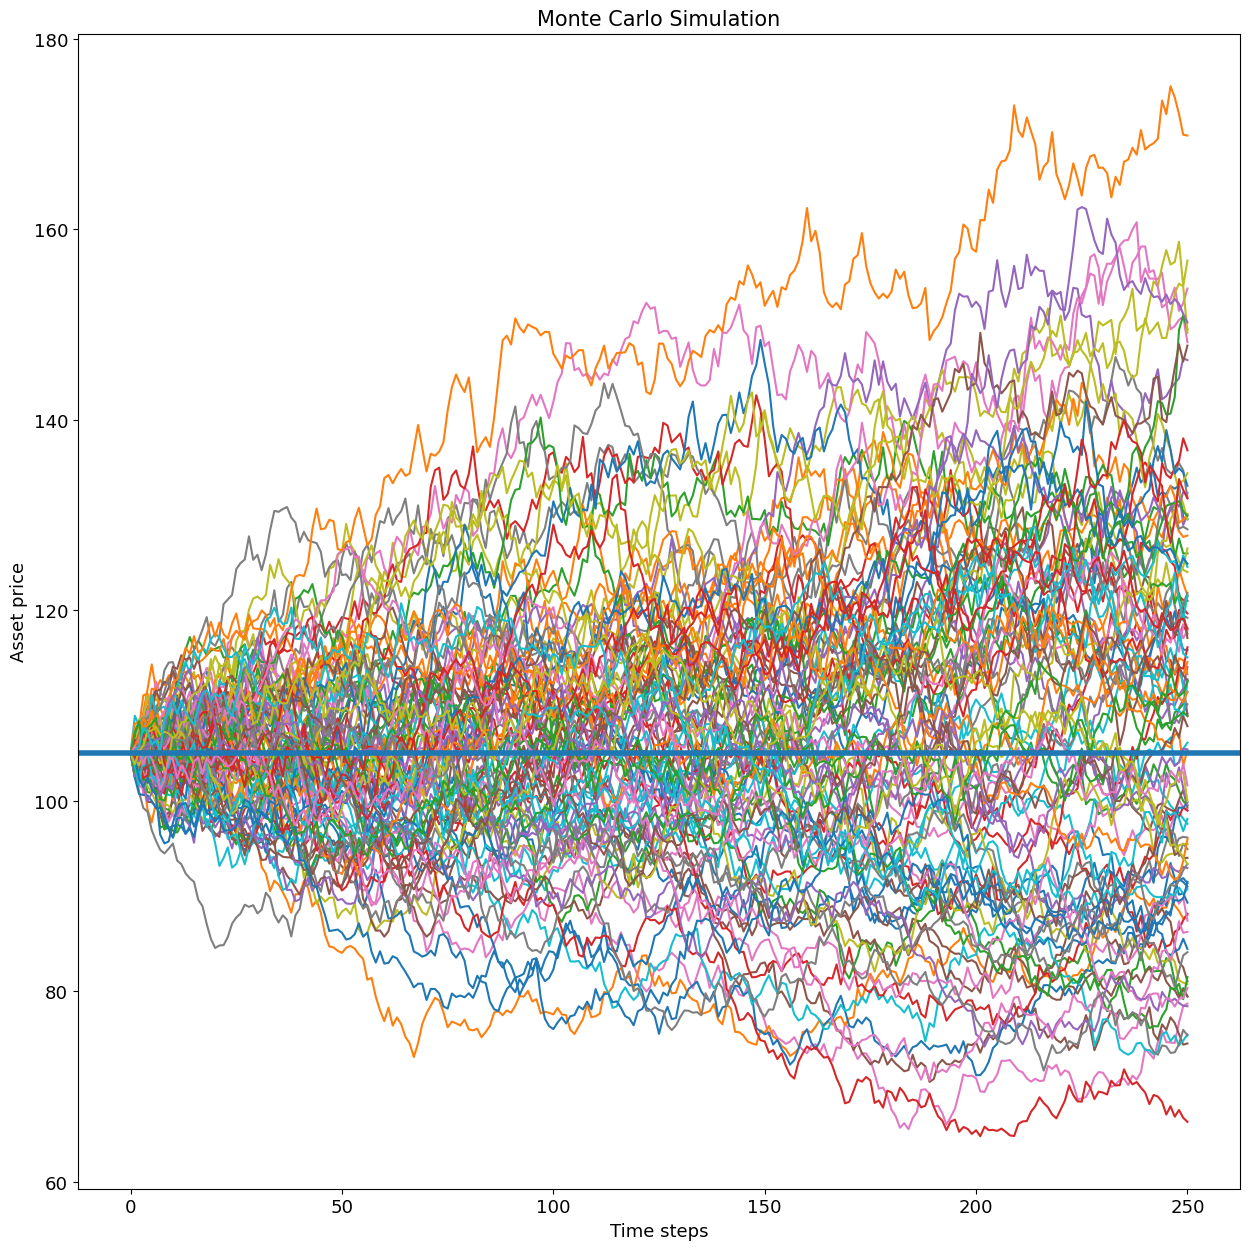

In [22]:
plt.figure(figsize=(15,15))
#plt.plot(paths)
for i in range(nsim):
    plt.plot(paths[i])
plt.axhline(y=S_0,linewidth=4)  
plt.xlabel(xlabel='Time steps',fontsize=13)    
plt.ylabel(ylabel='Asset price',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Monte Carlo Simulation',fontsize=15)
plt.show()    

### Сходимость цены по методу Монте-Карло к теоретической цене (BS)

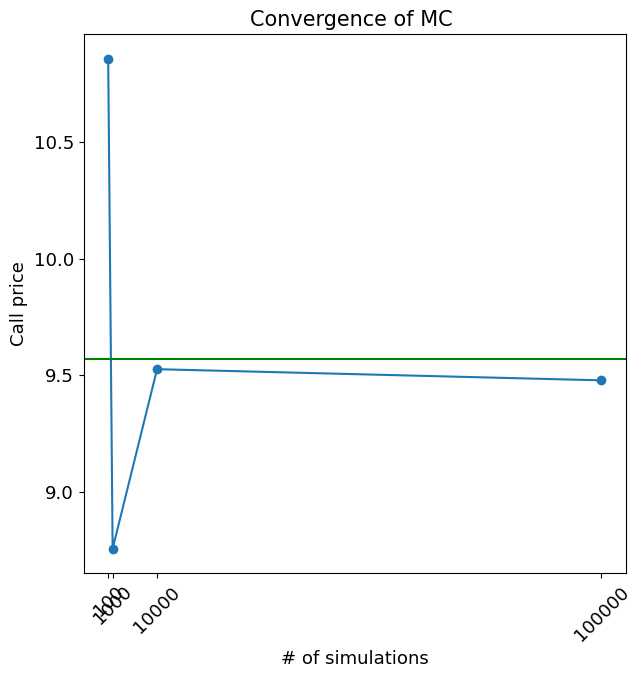

In [23]:
plt.figure(figsize=(7,7))
plt.plot(option_MC.index,option_MC['Call'], marker='o')
plt.axhline(option_call,color='green')
plt.xticks(list(option_MC.index),rotation=45,fontsize=10)
plt.xlabel(xlabel='# of simulations',fontsize=13)    
plt.ylabel(ylabel='Call price',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Convergence of MC ',fontsize=15)
plt.show()